# First we import required python libraries for Data Analysis or Visualizing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select data from Online and Load to Analysis that and Visualize that for Data Analysis

In [2]:
df = pd.read_csv("house_prices.csv")

In [3]:
df.head()

,Id,Area,Bedrooms,Bathrooms,Floors,YearBuilt,Location,Condition,Garage,Price
0,1,1360,5,4,3,1970,Downtown,Excellent,No,149919
1,2,4272,5,4,3,1958,Downtown,Excellent,No,424998
2,3,3592,2,2,3,1938,Downtown,Good,No,266746
3,4,966,4,2,2,1902,Suburban,Fair,Yes,244020
4,5,4926,1,4,2,1975,Downtown,Fair,Yes,636056


In [4]:
df.tail()

,Id,Area,Bedrooms,Bathrooms,Floors,YearBuilt,Location,Condition,Garage,Price
1995,1996,4994,5,4,3,1923,Suburban,Poor,No,295620
1996,1997,3046,5,2,1,2019,Suburban,Poor,Yes,580929
1997,1998,1062,5,1,2,1903,Rural,Poor,No,476925
1998,1999,4062,3,1,2,1936,Urban,Excellent,Yes,161119
1999,2000,2989,5,1,3,1903,Suburban,Fair,No,482525


# 1. Load and Explore Dataset

## 1.1. Check for missing values and handle them appropriately.

In [5]:
df.isnull().sum()

Id           0
Area         0
Bedrooms     0
Bathrooms    0
Floors       0
YearBuilt    0
Location     0
Condition    0
Garage       0
Price        0
dtype: int64

## 1.2. Analyze distributions of numerical variables (e.g., Size, Price).

In [6]:
numerical_cols = ["Price", "Area"]

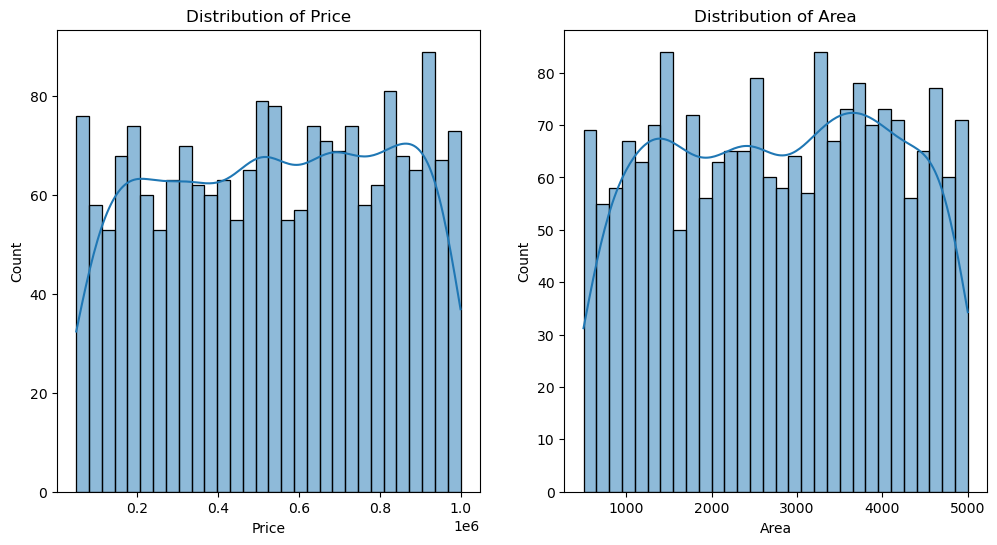

In [7]:
plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, 2, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
plt.show()

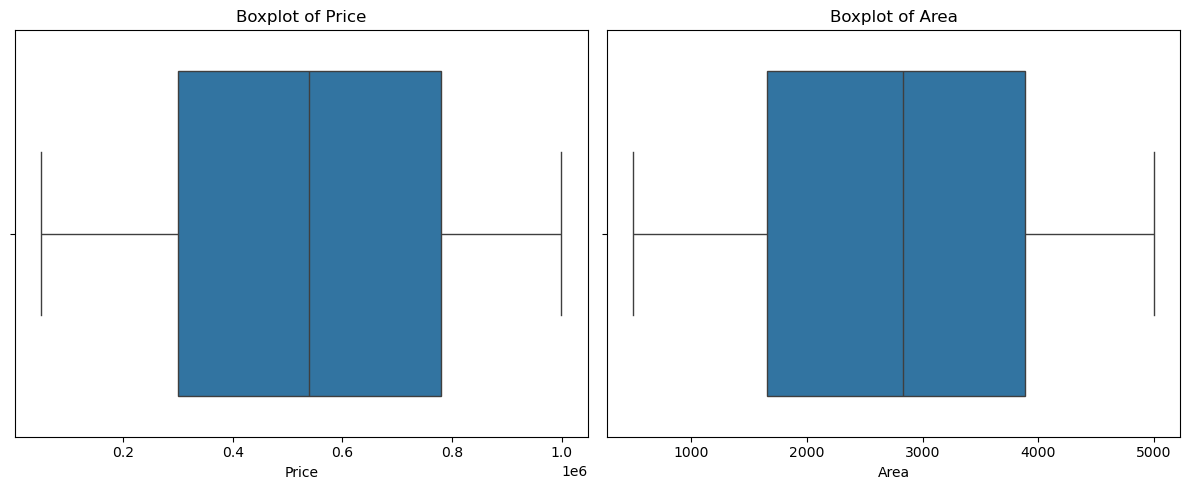

In [8]:
plt.figure(figsize=(12, 5))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

## 1.3. Identify potential outliers that might skew results.

In [9]:
outliers = {}
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]

outliers

{'Price': Series([], Name: Price, dtype: int64),
 'Area': Series([], Name: Area, dtype: int64)}

# 2. Data Preprocessing

## 2.1. Normalize Numerical Data:

### 2.1.1. Scale features like Size and Number of Rooms to bring them to a comparable range using methods like Min-Max Scaling or Standardization.


In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [11]:
features = [col for col in ['Area', 'Bedrooms'] if col in df.columns]

In [12]:
standard_scaler = StandardScaler()

In [13]:
standard_scaled = pd.DataFrame(standard_scaler.fit_transform(df[features]), columns=[f"{col}_std" for col in features])

In [14]:
min_max_scaler = MinMaxScaler()

In [15]:
min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df[features]), columns=[f"{col}_minmax" for col in features])

In [16]:
df_scaled = pd.concat([df, min_max_scaled, standard_scaled], axis=1)

In [17]:
df_scaled[[*features, *standard_scaled.columns, *min_max_scaled.columns]].head()


,Area,Bedrooms,Area_std,Bedrooms_std,Area_minmax,Bedrooms_minmax
0,1360,5,-1.101471,1.401791,0.190974,1.00
1,4272,5,1.147485,1.401791,0.838373,1.00
2,3592,2,0.622317,-0.704581,0.687194,0.25
3,966,4,-1.405759,0.699667,0.103379,0.75
4,4926,1,1.652574,-1.406705,0.983771,0.00


## 2.2 Encode Categorical Features:

### 2.2.1. Convert Location into numerical values using methods such as:
#### One-Hot Encoding for non-ordinal categories.
#### Label Encoding for ordinal categories (if any).

In [18]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [19]:
location_unique_values = df['Location'].unique()

In [20]:
one_hot_encoder = OneHotEncoder(sparse_output=False)

In [21]:
location_encoded = one_hot_encoder.fit_transform(df[['Location']])

In [22]:
location_encoded_df = pd.DataFrame(location_encoded, columns=one_hot_encoder.get_feature_names_out(['Location']))

In [23]:
df_encoded = pd.concat([df.drop(columns='Location'), location_encoded_df], axis=1)

In [24]:
df_encoded.head()

,Id,Area,Bedrooms,Bathrooms,Floors,YearBuilt,Condition,Garage,Price,Location_Downtown,Location_Rural,Location_Suburban,Location_Urban
0,1,1360,5,4,3,1970,Excellent,No,149919,1.0,0.0,0.0,0.0
1,2,4272,5,4,3,1958,Excellent,No,424998,1.0,0.0,0.0,0.0
2,3,3592,2,2,3,1938,Good,No,266746,1.0,0.0,0.0,0.0
3,4,966,4,2,2,1902,Fair,Yes,244020,0.0,0.0,1.0,0.0
4,5,4926,1,4,2,1975,Fair,Yes,636056,1.0,0.0,0.0,0.0


# 3. Feature Selection

## 3.1. Analyze Predictors:
#### Use correlation analysis to identify relationships between features and the target variable (Price).
#### Consider removing low-impact predictors to improve model performance.

In [25]:
condition_map = {
    'Poor': 1,
    'Fair': 2,
    'Good': 3,
    'Excellent': 4
}

In [26]:
df['Condition'] = df['Condition'].map(condition_map)

In [27]:
df['Garage'] = df['Garage'].map({'No': 0, 'Yes': 1})

In [28]:
location_dummies = pd.get_dummies(df['Location'], prefix='Location')

In [29]:
df = pd.concat([df, location_dummies], axis=1)

In [30]:
df_numeric = df.select_dtypes(include=['number'])

In [31]:
correlations = df_numeric.corr()

In [32]:
price_correlations = correlations['Price'].drop('Price').sort_values(ascending=0)

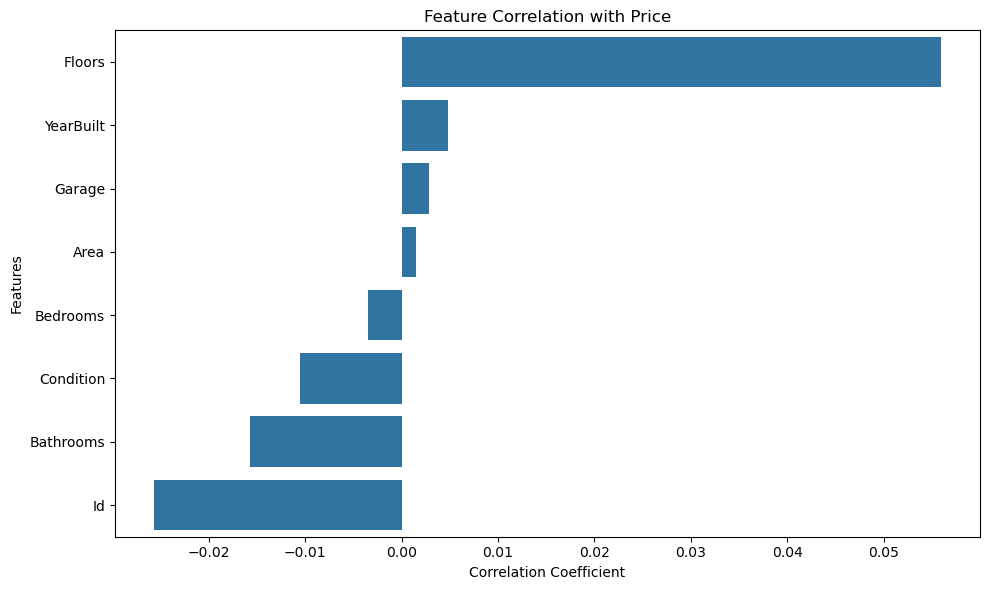

In [33]:
plt.figure(figsize=(10, 6))
sns.barplot(x=price_correlations.values, y=price_correlations.index)
plt.title('Feature Correlation with Price')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# 4. Model Training

## Import required libraries for linear regression model

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## 4.1. Train-Test Split:
#### Divide the dataset into training and testing sets (e.g., 80% train, 20% test). Ensure the split is random but reproducible.

In [35]:
X = df_numeric.drop(columns=['Price'])

In [36]:
y = df['Price']

In [37]:
X_encoded = pd.get_dummies(X, drop_first=True)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4.2. Use libraries like scikit-learn or similar tools to fit the regression model.

In [39]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [40]:
y_pred = model.predict(X_test)

# 5. Model Evaluation
##  Evaluation Metrics:
#### Calculate Root Mean Square Error (RMSE) to measure prediction accuracy.
#### Determine R² (Coefficient of Determination) to evaluate how well the model explains variability in the data.


In [41]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

In [42]:
mse

78860846730.38263

In [43]:
r2

-0.013650825220480334

In [44]:
rmse

280821.73478985316